In [33]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np

import wandb

#### Downloading Datasets

In [34]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

def normalize_img(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

Files already downloaded and verified
Files already downloaded and verified


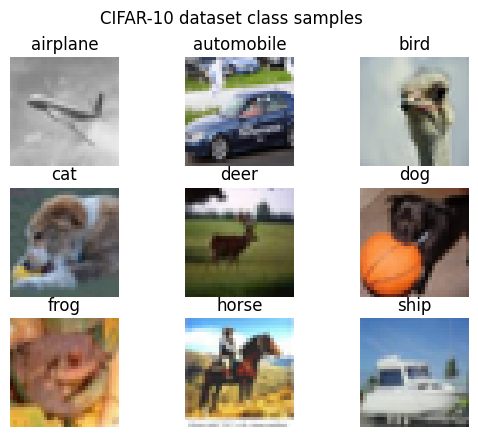

In [35]:
fig, axs = plt.subplots(3, 3)
fig.suptitle('CIFAR-10 dataset class samples')

independent_class_images = dict()

while len(independent_class_images) != 10:
    index = np.random.randint(0, len(cifar_trainset))
    image = cifar_trainset[index]
    independent_class_images[image[1]] = image[0]

for i in range(3):
    for j in range(3):
        axs[i, j].imshow(normalize_img(independent_class_images[i*3+j]))
        axs[i, j].set_title(cifar_trainset.classes[i*3+j])
        axs[i, j].axis('off')

plt.show()

In [36]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Base Functions

In [67]:
from torcheval.metrics import MulticlassAccuracy

def train(model: nn.Module, 
          optimizer, 
          criterion, 
          data_loader: torch.utils.data.DataLoader, 
          device,
          n_classes: int,
          verbose=True, verbose_interval=2000,
          current_epoch: int =1):
    acc = MulticlassAccuracy(num_classes=n_classes, device=device)

    running_loss = 0.0

    for i, data in enumerate(data_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        acc.update(outputs, labels)
        if verbose and i % verbose_interval == verbose_interval - 1:
            print(f'[Epoch {current_epoch}, {i + 1}] loss: {running_loss / verbose_interval:.3f}')
            running_loss = 0.0
    
    train_loss = running_loss / len(data_loader)

    return { "train_accuracy": acc.compute(), "train_loss": train_loss}

In [68]:
def test(model: nn.Module,
         criterion,
         data_loader: torch.utils.data.DataLoader,
         device,
         n_classes: int,
         verbose=True,
         ):
    accuracy = MulticlassAccuracy(num_classes=n_classes, device=device)
    
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            data, target = data.view(-1, 3, 32, 32), target
            y_true.append(target)

            output = model(data)
            y_pred.append(output)

            test_loss += criterion(output, target).item()

            class_pred = output.argmax(dim=1)

            accuracy.update(class_pred, target)
    
    test_loss /= len(data_loader.dataset)

    return { "test_accuracy": accuracy.compute(), "test_loss": test_loss}

In [69]:
from config import default_config
import torch.optim as optim

def assess_model(model: nn.Module, 
                 criterion, 
                 optimizer,
                 train_loader: torch.utils.data.DataLoader,
                 test_loader: torch.utils.data.DataLoader,
                 config=default_config,
                 learning_rate: float = 0.01,
                 n_epochs: int = 10,
                 n_classes: int = 10,
                 run_name: str = None
                ):
    torch.manual_seed(config["seed"])
    np.random.seed(config["seed"])

    if optimizer is None:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for m in model.modules():
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight)

    with wandb.init(project="del-mc1", 
                    name=run_name if run_name is not None else model.__class__.__name__, 
                    config=default_config
                    ) as run:
        use_cuda = torch.cuda.is_available()

        device = torch.device("cuda" if use_cuda else "cpu")
        model.to(device)

        torch.manual_seed(config["seed"]) 

        for epoch in range(1, n_epochs + 1):
            train_metrics = train(model, optimizer, criterion, train_loader, device, n_classes, current_epoch=epoch)
            test_metrics = test(model, criterion, test_loader, device, n_classes)
            
            print(f"Epoch {epoch} - Train accuracy: {train_metrics['train_accuracy']:.3f}, Test accuracy: {test_metrics['test_accuracy']:.3f}")

            wandb.log({"epoch": epoch, 
                       **train_metrics, 
                       **test_metrics})


## Base Model

In [70]:
def BaseCNN():
    return nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(4096 , 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )


## Overfit Testing

In [83]:
print(cifar_trainset[0])

random_sample_of_trainset = torch.utils.data.DataLoader(cifar_trainset[0])

for i, data in enumerate(random_sample_of_trainset):
    print(f'{i}: {data}')
    #print(f'{i}: {data[0].shape}, {data[1].shape}')
    break

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0.8431, -1.0000, -1.0000,  ..., -

In [72]:
base_model = BaseCNN()

train_loader = torch.utils.data.Subset(cifar_trainset, np.random.choice(len(cifar_trainset), 1, replace=False))
test_loader = torch.utils.data.Subset(cifar_trainset, np.random.choice(len(cifar_trainset), 1, replace=False))

assess_model(base_model, 
             nn.CrossEntropyLoss(), 
             None, 
             train_loader, 
             test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             n_classes=1)

Traceback (most recent call last):
  File "/var/folders/th/yt_529gn5qj62429rgx8mqzc0000gn/T/ipykernel_85581/2230804061.py", line 37, in assess_model
    train_metrics = train(model, optimizer, criterion, train_loader, device, n_classes, current_epoch=epoch)
  File "/var/folders/th/yt_529gn5qj62429rgx8mqzc0000gn/T/ipykernel_85581/3204903923.py", line 16, in train
    inputs, labels = data[0].to(device), data[1].to(device)
AttributeError: 'int' object has no attribute 'to'
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


AttributeError: 'int' object has no attribute 'to'